In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']


In [2]:
df_original = pd.read_csv('/Users/fakue/Desktop/taobao_persona.csv')
df_original.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11


# 数据预处理

## 数据抽样

In [3]:
df = df_original.sample(frac=0.2, random_state=None)

In [4]:
import gc
del df_original
gc.collect()

7

## 缺失值处理

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658205 entries, 14963846 to 18097551
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 248.8+ MB


In [6]:
df.shape

(4658205, 6)

In [7]:
df.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     3182593
item_category          0
time                   0
dtype: int64

In [8]:
#删除缺失值过多的user_geohash字段
df.drop('user_geohash', axis=1, inplace=True)

## 日期与时段处理

In [9]:
#将time字段拆分为日期与时段
df['date'] = df['time'].str[0:10]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['time'] = df['time'].str[11:]
df['time'] = df['time'].astype(int)
df.head()

,user_id,item_id,behavior_type,item_category,time,date
14963846,58475394,90645523,1,2733,21,2014-12-10
10231374,12661032,396444169,1,7572,15,2014-11-21
13697629,4252574,96528684,1,11279,21,2014-12-03
547391,10713699,257913150,1,6513,20,2014-11-30
5418064,35111239,252364734,1,11279,21,2014-12-16


In [10]:
#将时段分为'凌晨'、'上午'、'中午'、'下午'、'晚上'
df['hour'] = pd.cut(df['time'], bins=[-1, 5, 10, 13, 18, 24], labels=['凌晨','上午','中午','下午','晚上'])
df.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
14963846,58475394,90645523,1,2733,21,2014-12-10,晚上
10231374,12661032,396444169,1,7572,15,2014-11-21,下午
13697629,4252574,96528684,1,11279,21,2014-12-03,晚上
547391,10713699,257913150,1,6513,20,2014-11-30,晚上
5418064,35111239,252364734,1,11279,21,2014-12-16,晚上


## 制作用户标签表

In [11]:
#生成用户标签表，制作好的标签都加入这个表中
users = df['user_id'].unique()
labels = pd.DataFrame(users, columns=['user_id'])

# 用户行为标签

## 用户浏览活跃时间段

In [12]:
#对用户和时段分组，统计浏览次数
time_browse = df[df['behavior_type'] == 1].groupby(['user_id', 'hour']).item_id.count().reset_index()
time_browse.rename(columns={'item_id':'hour_counts'},inplace=True)
time_browse

,user_id,hour,hour_counts
0,492,上午,7
1,492,中午,9
2,492,下午,6
3,492,晚上,30
4,3726,凌晨,1
5,3726,上午,1
6,3726,中午,10
7,3726,下午,16
8,3726,晚上,41
9,19137,凌晨,2


In [13]:
#统计每个用户浏览次数最多的时段
time_browse_max = time_browse.groupby(['user_id']).hour_counts.max().reset_index()
time_browse_max.rename(columns={'hour_counts':'read_counts_max'},inplace=True)
time_browse_max

,user_id,read_counts_max
0,492,30
1,3726,41
2,19137,8
3,36465,9
4,37101,54
5,38745,64
6,45561,112
7,53394,7
8,59436,103
9,60552,4


In [14]:
time_browse = pd.merge(time_browse, time_browse_max, how='left', on='user_id')
time_browse

,user_id,hour,hour_counts,read_counts_max
0,492,上午,7,30
1,492,中午,9,30
2,492,下午,6,30
3,492,晚上,30,30
4,3726,凌晨,1,41
5,3726,上午,1,41
6,3726,中午,10,41
7,3726,下午,16,41
8,3726,晚上,41,41
9,19137,凌晨,2,8


In [15]:
#选取各用户浏览次数最多的时段，如有并列最多的时段，用逗号连接
time_browse_hour = time_browse.loc[time_browse['hour_counts'] == time_browse['read_counts_max'], 'hour'].groupby(time_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
time_browse_hour

,user_id,hour
0,492,晚上
1,3726,晚上
2,19137,晚上
3,36465,下午
4,37101,下午
5,38745,晚上
6,45561,上午
7,53394,晚上
8,59436,晚上
9,60552,中午


In [16]:
#将用户浏览活跃时间段加入到用户标签表中
labels = pd.merge(labels, time_browse_hour, how='left', on='user_id')
labels.rename(columns={'hour':'time_browse'}, inplace=True)
labels

,user_id,time_browse
0,58475394,下午
1,12661032,上午
2,4252574,上午
3,10713699,晚上
4,35111239,晚上
5,110937247,晚上
6,132791225,下午
7,103044784,晚上
8,21578001,下午
9,62189225,晚上


## 用户购买活跃时间段

In [17]:
#生成逻辑与浏览活跃时间段相同
time_buy = df[df['behavior_type'] == 4].groupby(['user_id', 'hour']).item_id.count().reset_index()
time_buy.rename(columns={'item_id':'hour_counts'}, inplace=True)
time_buy_max = time_buy.groupby(['user_id']).hour_counts.max().reset_index()
time_buy_max.rename(columns={'hour_counts':'buy_counts_max'}, inplace=True)
time_buy = pd.merge(time_buy, time_buy_max, how='left', on='user_id')
time_buy_hour = time_buy.loc[time_buy['hour_counts'] == time_buy['buy_counts_max'], 'hour'].groupby(time_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [18]:
time_buy_hour

,user_id,hour
0,37101,下午
1,45561,"上午,中午"
2,59436,"下午,晚上"
3,61797,中午
4,100605,晚上
5,106362,中午
6,131694,下午
7,137907,晚上
8,160959,晚上
9,169005,上午


In [19]:
#将用户购买活跃时间段加入到用户标签表中
labels = pd.merge(labels, time_browse_hour, how='left', on='user_id')
labels.rename(columns={'hour':'time_buy'}, inplace=True)
labels

,user_id,time_browse,time_buy
0,58475394,下午,下午
1,12661032,上午,上午
2,4252574,上午,上午
3,10713699,晚上,晚上
4,35111239,晚上,晚上
5,110937247,晚上,晚上
6,132791225,下午,下午
7,103044784,晚上,晚上
8,21578001,下午,下午
9,62189225,晚上,晚上


In [20]:
del time_browse
del time_buy
del time_browse_hour
del time_browse_max
del time_buy_hour
del time_buy_max
gc.collect()

119

## 关于类目的用户行为

In [21]:
df_browse = df.loc[df['behavior_type'] == 1, ['user_id','item_id','item_category']]
df_collect = df.loc[df['behavior_type']==2,['user_id','item_id','item_category']]
df_cart = df.loc[df['behavior_type']==3,['user_id','item_id','item_category']]
df_buy = df.loc[df['behavior_type']==4,['user_id','item_id','item_category']]

### 浏览最多的类目

In [22]:
#对用户与类目进行分组，统计浏览次数
df_cate_most_browse = df_browse.groupby(['user_id', 'item_category']).item_id.count().reset_index()
df_cate_most_browse

,user_id,item_category,item_id
0,492,2170,6
1,492,2413,1
2,492,3424,1
3,492,4640,1
4,492,6000,2
5,492,6247,3
6,492,6344,11
7,492,6648,1
8,492,7094,1
9,492,7440,3


In [23]:
df_cate_most_browse.rename(columns={'item_id':'item_category_counts'}, inplace=True)

In [24]:
#统计每个用户浏览次数最多的类目
df_cate_most_browse_max = df_cate_most_browse.groupby(['user_id']).item_category_counts.max().reset_index()
df_cate_most_browse_max.rename(columns={'item_category_counts':'item_category_counts_max'}, inplace=True)
df_cate_most_browse_max

,user_id,item_category_counts_max
0,492,11
1,3726,6
2,19137,2
3,36465,4
4,37101,60
5,38745,56
6,45561,24
7,53394,7
8,59436,19
9,60552,2


In [25]:
df_cate_most_browse = pd.merge(df_cate_most_browse, df_cate_most_browse_max, how='left', on='user_id')
df_cate_most_browse

,user_id,item_category,item_category_counts,item_category_counts_max
0,492,2170,6,11
1,492,2413,1,11
2,492,3424,1,11
3,492,4640,1,11
4,492,6000,2,11
5,492,6247,3,11
6,492,6344,11,11
7,492,6648,1,11
8,492,7094,1,11
9,492,7440,3,11


In [26]:
df_cate_most_browse['item_category'] = df_cate_most_browse['item_category'].astype(str)
df_cate_most_browse

,user_id,item_category,item_category_counts,item_category_counts_max
0,492,2170,6,11
1,492,2413,1,11
2,492,3424,1,11
3,492,4640,1,11
4,492,6000,2,11
5,492,6247,3,11
6,492,6344,11,11
7,492,6648,1,11
8,492,7094,1,11
9,492,7440,3,11


In [27]:
#选取各用户浏览次数最多的类目，如有并列最多的类目，用逗号连接
df_cate_browse = df_cate_most_browse.loc[df_cate_most_browse['item_category_counts'] == df_cate_most_browse['item_category_counts_max'], 'item_category'].groupby(df_cate_most_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
#将用户浏览最多的类目加入到用户标签表中
labels = pd.merge(labels,df_cate_browse,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_browse'},inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse
0,58475394,下午,下午,9517
1,12661032,上午,上午,5932
2,4252574,上午,上午,1863
3,10713699,晚上,晚上,6513
4,35111239,晚上,晚上,13230
5,110937247,晚上,晚上,5027
6,132791225,下午,下午,1863
7,103044784,晚上,晚上,9569
8,21578001,下午,下午,6513
9,62189225,晚上,晚上,5232


### 收藏最多的类目

In [28]:
#生成逻辑与浏览最多的类目相同
df_cate_most_collect = df_collect.groupby(['user_id', 'item_category']).item_id.count().reset_index()
df_cate_most_collect.rename(columns={'item_id':'item_category_counts'}, inplace=True)
df_cate_most_collect_max = df_cate_most_collect.groupby(['user_id']).item_category_counts.max().reset_index()
df_cate_most_collect_max.rename(columns={'item_category_counts':'item_category_counts_max'}, inplace=True)
df_cate_most_collect = pd.merge(df_cate_most_collect, df_cate_most_collect_max, how='left', on='user_id')
df_cate_most_collect['item_category'] = df_cate_most_collect['item_category'].astype(str)
df_cate_collect = df_cate_most_collect.loc[df_cate_most_collect['item_category_counts'] == df_cate_most_collect['item_category_counts_max'], 'item_category'].groupby(df_cate_most_collect['user_id']).aggregate(lambda x:','.join(x)).reset_index()
labels = pd.merge(labels, df_cate_collect, how='left', on='user_id')
labels.rename(columns={'item_category':'cate_most_collect'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678"
1,12661032,上午,上午,5932,NaN
2,4252574,上午,上午,1863,5894
3,10713699,晚上,晚上,6513,6513
4,35111239,晚上,晚上,13230,2883
5,110937247,晚上,晚上,5027,NaN
6,132791225,下午,下午,1863,NaN
7,103044784,晚上,晚上,9569,NaN
8,21578001,下午,下午,6513,"5689,6513"
9,62189225,晚上,晚上,5232,12685


### 加购最多的类目

In [29]:
df_cate_most_cart = df_cart.groupby(['user_id', 'item_category']).item_id.count().reset_index()
df_cate_most_cart.rename(columns={'item_id':'item_category_counts'}, inplace=True)
df_cate_most_cart_max = df_cate_most_cart.groupby(['user_id']).item_category_counts.max().reset_index()
df_cate_most_cart_max.rename(columns={'item_category_counts':'item_category_counts_max'}, inplace=True)
df_cate_most_cart = pd.merge(df_cate_most_cart, df_cate_most_cart_max, how='left', on='user_id')
df_cate_most_cart['item_category'] = df_cate_most_cart['item_category'].astype(str)
df_cate_cart = df_cate_most_cart.loc[df_cate_most_cart['item_category_counts'] == df_cate_most_cart['item_category_counts_max'], 'item_category'].groupby(df_cate_most_cart['user_id']).aggregate(lambda x:','.join(x)).reset_index()
labels = pd.merge(labels, df_cate_cart, how='left', on='user_id')
labels.rename(columns={'item_category':'cate_most_cart'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517"
1,12661032,上午,上午,5932,NaN,NaN
2,4252574,上午,上午,1863,5894,11279
3,10713699,晚上,晚上,6513,6513,13541
4,35111239,晚上,晚上,13230,2883,5503
5,110937247,晚上,晚上,5027,NaN,"5204,5271"
6,132791225,下午,下午,1863,NaN,"1863,3472"
7,103044784,晚上,晚上,9569,NaN,9569
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489"
9,62189225,晚上,晚上,5232,12685,NaN


### 购买最多的类目

In [30]:
df_cate_most_buy = df_buy.groupby(['user_id', 'item_category']).item_id.count().reset_index()
df_cate_most_buy.rename(columns={'item_id':'item_category_counts'}, inplace=True)
df_cate_most_buy_max = df_cate_most_buy.groupby(['user_id']).item_category_counts.max().reset_index()
df_cate_most_buy_max.rename(columns={'item_category_counts':'item_category_counts_max'}, inplace=True)
df_cate_most_buy = pd.merge(df_cate_most_buy, df_cate_most_buy_max, how='left', on='user_id')
df_cate_most_buy['item_category'] = df_cate_most_buy['item_category'].astype(str)
df_cate_buy = df_cate_most_buy.loc[df_cate_most_buy['item_category_counts'] == df_cate_most_buy['item_category_counts_max'], 'item_category'].groupby(df_cate_most_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()
labels = pd.merge(labels, df_cate_buy, how='left', on='user_id')
labels.rename(columns={'item_category':'cate_most_buy'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90..."
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304"
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756"
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695"
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561"
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659
6,132791225,下午,下午,1863,NaN,"1863,3472",6344
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170"
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513"
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9..."


In [31]:
del df_browse
del df_collect
del df_cart
del df_buy
del df_cate_most_browse
del df_cate_most_collect
del df_cate_most_buy
del df_cate_most_cart
del df_cate_most_browse_max
del df_cate_most_collect_max
del df_cate_most_cart_max
del df_cate_most_buy_max
del df_cate_browse
del df_cate_collect
del df_cate_cart
del df_cate_buy
gc.collect(0)

0

## 30天用户行为

### 近30天购买次数

In [32]:
df_counts_30_buy = df[df['behavior_type'] == 4].groupby(['user_id']).item_id.count().reset_index()
df_counts_30_buy

,user_id,item_id
0,37101,1
1,45561,2
2,59436,2
3,61797,1
4,100605,3
5,106362,3
6,131694,3
7,137907,1
8,160959,4
9,169005,10


In [33]:
labels = pd.merge(labels, df_counts_30_buy, how='left', on='user_id')
labels.rename(columns={'item_id':'counts_30_buy'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0


### 近30天加购次数

In [34]:
#将加购行为按用户进行分组，统计次数
df_counts_30_cart = df[df['behavior_type'] == 3].groupby(['user_id']).item_id.count().reset_index()
labels = pd.merge(labels, df_counts_30_cart, how='left', on='user_id')
labels.rename(columns={'item_id':'counts_30_cart'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN


### 近30天活跃天数

In [35]:
counts_30_active = df.groupby('user_id')['date'].nunique().reset_index()
counts_30_active

,user_id,date
0,492,13
1,3726,13
2,19137,6
3,36465,5
4,37101,20
5,38745,15
6,45561,29
7,53394,7
8,59436,18
9,60552,3


In [36]:
labels = pd.merge(labels, counts_30_active, how='left', on='user_id')
labels.rename(columns={'date':'counts_30_active'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30


In [37]:
del df_counts_30_buy
del df_counts_30_cart
del counts_30_active
gc.collect()

140

## 7天用户行为

In [38]:
#数据集中的最后日期是12月18号，统计11号之后的用户行为
df_near_7 = df[df['date'] > datetime.strptime('2014-12-11', '%Y-%m-%d')]
df_near_7

,user_id,item_id,behavior_type,item_category,time,date,hour
5418064,35111239,252364734,1,11279,21,2014-12-16,晚上
959075,110937247,287120988,1,5232,23,2014-12-12,晚上
9657194,118444341,402593074,1,3431,20,2014-12-16,晚上
10862392,134519193,19151315,1,10533,20,2014-12-15,晚上
16210425,110269699,117350464,1,10037,18,2014-12-14,下午
19759959,23363791,361102628,1,5369,1,2014-12-13,凌晨
18699040,138954193,218102463,1,10894,12,2014-12-13,中午
603554,10771734,212280028,1,5232,21,2014-12-14,晚上
5669501,38195252,132295918,1,5388,20,2014-12-13,晚上
18878636,14104719,362259154,1,1083,0,2014-12-15,凌晨


### 近7天购买次数

In [39]:
df_counts_7_buy = df_near_7[df_near_7['behavior_type'] == 4].groupby(['user_id']).item_id.count().reset_index()
df_counts_7_buy

,user_id,item_id
0,45561,2
1,59436,2
2,100605,1
3,169005,3
4,173019,2
5,182343,1
6,186960,6
7,190518,4
8,205326,1
9,219885,1


In [40]:
labels = pd.merge(labels, df_counts_7_buy, how='left', on='user_id')
labels.rename(columns={'item_id':'counts_7_buy'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0


### 近7天加购次数

In [41]:
df_counts_7_cart = df_near_7[df_near_7['behavior_type'] == 3].groupby(['user_id']).item_id.count().reset_index()
labels = pd.merge(labels, df_counts_7_cart, how='left', on='user_id')
labels.rename(columns={'item_id':'counts_7_cart'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN


### 近7天活跃天数

In [42]:
counts_7_active = df_near_7.groupby(['user_id'])['date'].nunique().reset_index()
counts_7_active

,user_id,date
0,492,5
1,3726,4
2,36465,2
3,37101,5
4,38745,5
5,45561,7
6,53394,2
7,59436,6
8,60723,3
9,61797,6


In [43]:
labels = pd.merge(labels, counts_7_active, how='left', on='user_id')
labels.rename(columns={'date':'counts_7_active'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0


In [44]:
del df_counts_7_buy
del df_counts_7_cart
del counts_7_active
gc.collect()

77

## 最后一次行为距今天数

### 上次浏览距今天数

In [45]:
days_browse = df[df['behavior_type'] == 1].groupby(['user_id'])['date'].max().apply(lambda x:(datetime.strptime('2014-12-19', '%Y-%m-%d') - x).days).reset_index()
days_browse

,user_id,date
0,492,1
1,3726,1
2,19137,12
3,36465,3
4,37101,3
5,38745,1
6,45561,1
7,53394,5
8,59436,1
9,60552,10


In [46]:
labels = pd.merge(labels, days_browse, how='left', on='user_id')
labels.rename(columns={'date':'days_browse'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0


### 上次加购距今天数

In [47]:
days_cart = df[df['behavior_type'] == 3].groupby(['user_id'])['date'].max().apply(lambda x:(datetime.strptime('2014-12-19', '%Y-%m-%d') - x).days).reset_index()
labels = pd.merge(labels, days_cart, how='left', on='user_id')
labels.rename(columns={'date':'days_cart'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN


### 上次购买距今天数

In [48]:
days_buy = df[df['behavior_type'] == 4].groupby(['user_id'])['date'].max().apply(lambda x:(datetime.strptime('2014-12-19', '%Y-%m-%d') - x).days).reset_index()
labels = pd.merge(labels, days_buy, how='left', on='user_id')
labels.rename(columns={'date':'days_buy'}, inplace=True)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0,4.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN,1.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0,2.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0,7.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0,18.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0,23.0
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0,3.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0,1.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0,7.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN,1.0


In [49]:
del days_browse
del days_buy
del days_cart
gc.collect()

49

## 最近两天购买间隔天数

In [50]:
df_interval_buy = df[df['behavior_type'] == 4].groupby(['user_id', 'date']).item_id.count().reset_index()
df_interval_buy

,user_id,date,item_id
0,37101,2014-12-08,1
1,45561,2014-12-12,1
2,45561,2014-12-13,1
3,59436,2014-12-12,1
4,59436,2014-12-18,1
5,61797,2014-12-03,1
6,100605,2014-11-24,2
7,100605,2014-12-12,1
8,106362,2014-12-06,1
9,106362,2014-12-09,1


In [51]:
interval_buy = df_interval_buy.groupby(['user_id'])['date'].apply(lambda x: x.sort_values().diff(1).dropna().head(1)).reset_index()
interval_buy['date'] = interval_buy['date'].apply(lambda x: x.days)
interval_buy

,user_id,level_1,date
0,45561,2,1
1,59436,4,6
2,100605,7,18
3,106362,9,3
4,131694,12,5
5,160959,15,4
6,169005,19,1
7,173019,27,14
8,186960,32,4
9,190518,37,6


In [52]:
interval_buy.drop(['level_1'], axis=1, inplace=True)
interval_buy.rename(columns={'date':'interval_buy'}, inplace=True)
interval_buy

,user_id,interval_buy
0,45561,1
1,59436,6
2,100605,18
3,106362,3
4,131694,5
5,160959,4
6,169005,1
7,173019,14
8,186960,4
9,190518,6


In [53]:
labels = pd.merge(labels, interval_buy,how='left', on='user_id')
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0,4.0,4.0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN,1.0,2.0
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0,2.0,1.0
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0,7.0,17.0
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0,18.0,6.0
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0,23.0,NaN
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0,3.0,3.0
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0,1.0,3.0
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0,7.0,14.0
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN,1.0,9.0


In [54]:
del df_interval_buy
gc.collect()

56

## 是否浏览未下单

In [55]:
df_browse_buy = df.loc[(df['behavior_type'] == 1) | (df['behavior_type'] == 4), ['user_id', 'item_id', 'behavior_type', 'time']]
df_browse_buy

,user_id,item_id,behavior_type,time
14963846,58475394,90645523,1,21
10231374,12661032,396444169,1,15
13697629,4252574,96528684,1,21
547391,10713699,257913150,1,20
5418064,35111239,252364734,1,21
959075,110937247,287120988,1,23
18142590,132791225,108426160,1,10
234997,103044784,368234102,1,23
4204977,21578001,260764485,1,11
22992975,62189225,271483205,1,22


In [56]:
browse_not_buy = pd.pivot_table(df_browse_buy, index=['user_id', 'item_id'], columns=['behavior_type'], values=['time'], aggfunc=['count'])
browse_not_buy

count    
                     time    
behavior_type           1   4
user_id   item_id            
492       254885      4.0 NaN
          6983065     1.0 NaN
          8977055     1.0 NaN
          30541025    1.0 NaN
          50834828    2.0 NaN
          59758671    1.0 NaN
          65264993    1.0 NaN
          66870920    1.0 NaN
          68197904    1.0 NaN
          91901274    3.0 NaN
          110036513   1.0 NaN
          145020682   1.0 NaN
          162582909   2.0 NaN
          169720786   5.0 NaN
          172268231   1.0 NaN
          174275461   1.0 NaN
          175627215   1.0 NaN
          185014660   2.0 NaN
          187717177   1.0 NaN
          190935268   1.0 NaN
          195583171   1.0 NaN
          199638541   1.0 NaN
          213642652   1.0 NaN
          239525601   1.0 NaN
          243642604   1.0 NaN
          245229122   1.0 NaN
          256823812   1.0 NaN
          262056903   1.0 NaN
          283593531   1.0 NaN
          315155318   1.0 NaN
...                   ...  ..
142442955 236762628   1.0 NaN
          260934112   1.0 NaN
          262078972   1.0 NaN
          282885107   1.0 NaN
          289527020   1.0 NaN
          289909752   1.0 NaN
          297112487   1.0 NaN
          302654533   1.0 NaN
          303511188   1.0 NaN
          304652834   1.0 NaN
          308163967   2.0 NaN
          315209681   1.0 NaN
          325938147   1.0 NaN
          328497188   1.0 NaN
          334633785   1.0 NaN
          336312235   1.0 NaN
          337142452   1.0 NaN
          338157304   1.0 NaN
          348674425   1.0 NaN
          354387341   1.0 NaN
          358670663   1.0 NaN
          361974915   1.0 NaN
          364397686   1.0 NaN
          381803895   1.0 NaN
          382478520   1.0 NaN
          384108886   1.0 NaN
          386680968   1.0 NaN
          390480283   1.0 NaN
          391981437   1.0 NaN
          403495818   1.0 NaN

[3387309 rows x 2 columns]

In [57]:
browse_not_buy.columns=['browse', 'buy']
browse_not_buy.fillna(0, inplace=True)
browse_not_buy['browse_not_buy'] = 0
browse_not_buy.loc[(browse_not_buy['browse'] > 0) & (browse_not_buy['buy'] == 0), 'browse_not_buy'] = 1
browse_not_buy = browse_not_buy.groupby(['user_id'])['browse_not_buy'].sum().reset_index()
browse_not_buy

,user_id,browse_not_buy
0,492,38
1,3726,53
2,19137,13
3,36465,8
4,37101,101
5,38745,133
6,45561,303
7,53394,12
8,59436,140
9,60552,10


In [58]:
labels = pd.merge(labels, browse_not_buy, how='left', on='user_id')
labels['browse_not_buy'] = labels['browse_not_buy'].apply(lambda x: '是' if x > 0 else '否')
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0,4.0,4.0,是
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN,1.0,2.0,是
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0,2.0,1.0,是
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0,7.0,17.0,是
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0,18.0,6.0,是
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0,23.0,NaN,是
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0,3.0,3.0,是
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0,1.0,3.0,是
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0,7.0,14.0,是
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN,1.0,9.0,是


## 是否加购未下单

In [59]:
df_cart_buy = df.loc[(df['behavior_type'] == 3) | (df['behavior_type'] == 4), ['user_id', 'item_id', 'behavior_type', 'time']]
cart_not_buy = pd.pivot_table(df_cart_buy, index=['user_id', 'item_id'], columns=['behavior_type'], values=['time'], aggfunc=['count'])
cart_not_buy.columns=['cart', 'buy']
cart_not_buy.fillna(0, inplace=True)
cart_not_buy['cart_not_buy'] = 0
cart_not_buy.loc[(cart_not_buy['cart'] > 0) & (cart_not_buy['buy'] == 0), 'cart_not_buy'] = 1
cart_not_buy = cart_not_buy.groupby(['user_id'])['cart_not_buy'].sum().reset_index()
labels = pd.merge(labels, cart_not_buy, how='left', on='user_id')
labels['cart_not_buy'] = labels['cart_not_buy'].apply(lambda x: '是' if x > 0 else '否')
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0,4.0,4.0,是,是
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN,1.0,2.0,是,否
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0,2.0,1.0,是,是
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0,7.0,17.0,是,是
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0,18.0,6.0,是,是
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0,23.0,NaN,是,是
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0,3.0,3.0,是,是
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0,1.0,3.0,是,是
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0,7.0,14.0,是,是
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN,1.0,9.0,是,否


# 用户属性标签

## 是否复购用户

In [60]:
buy_again = df[df['behavior_type'] == 4].groupby(['user_id']).item_id.count().reset_index()
buy_again

,user_id,item_id
0,37101,1
1,45561,2
2,59436,2
3,61797,1
4,100605,3
5,106362,3
6,131694,3
7,137907,1
8,160959,4
9,169005,10


In [61]:
buy_again.rename(columns={'item_id':'buy_again'}, inplace=True)
buy_again.head()

,user_id,buy_again
0,37101,1
1,45561,2
2,59436,2
3,61797,1
4,100605,3


In [62]:
labels = pd.merge(labels, buy_again, how='left', on='user_id')
labels['buy_again'].fillna(0, inplace=True)
labels['buy_again'] = labels['buy_again'].apply(lambda x: '是' if x>1 else '否' if x==1 else '未购买').reset_index()
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,9.0,4.0,7.0,1.0,3.0,4.0,4.0,是,是,0
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,1.0,NaN,5.0,1.0,NaN,1.0,2.0,是,否,1
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,1.0,NaN,7.0,1.0,8.0,2.0,1.0,是,是,2
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,2.0,4.0,7.0,1.0,1.0,7.0,17.0,是,是,3
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,NaN,NaN,7.0,1.0,9.0,18.0,6.0,是,是,4
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,NaN,1.0,4.0,1.0,7.0,23.0,NaN,是,是,5
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,3.0,6.0,7.0,1.0,3.0,3.0,3.0,是,是,6
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,2.0,3.0,7.0,1.0,4.0,1.0,3.0,是,是,7
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,1.0,NaN,7.0,1.0,16.0,7.0,14.0,是,是,8
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,4.0,NaN,7.0,1.0,NaN,1.0,9.0,是,否,9


## 访问活跃度

In [63]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False)
user_active_level

31    748
30    728
29    806
28    710
27    759
26    769
25    802
24    770
23    775
22    757
21    772
20    726
19    739
18    728
17    718
16    750
15    665
14    641
13    653
12    605
11    670
10    606
9     556
8     577
7     538
6     490
5     426
4     459
3     388
2     373
1     250
Name: counts_30_active, dtype: int64

Text(0.5,0,'访问次数')

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

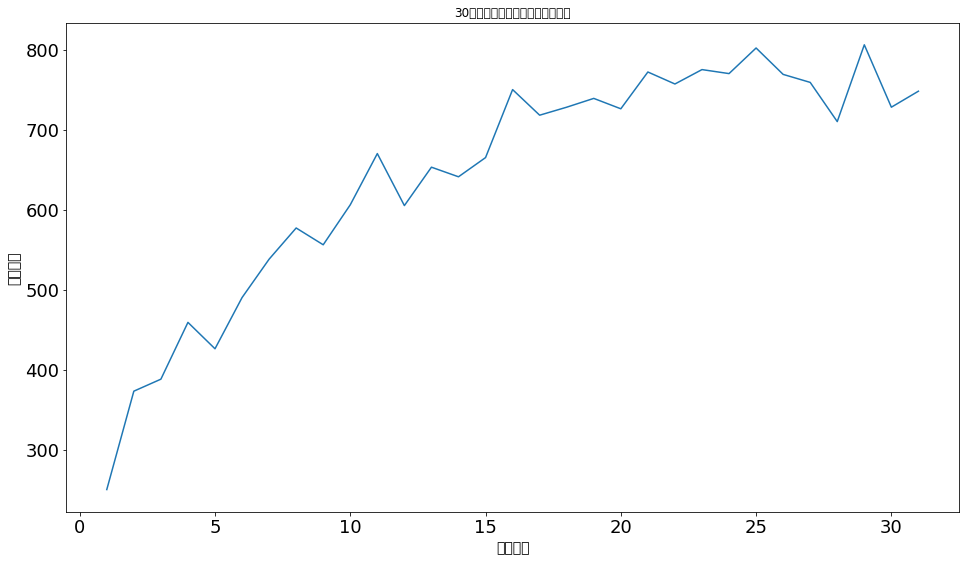

In [64]:
plt.figure(figsize=(16, 9))
plt.rc('font', family='Micosoft YaHei')
user_active_level.plot(title='30天内访问次数与访问人数的关系', fontsize=18)
plt.ylabel('访问人数', fontsize=14)
plt.xlabel('访问次数', fontsize=14)

In [65]:
#定义访问次数小于等于16次的为低活跃，访问次数大于16次的定义为高活跃
labels['user_active_level'] = '高' 
labels.loc[labels['counts_30_active'] <= 16, 'user_active_level'] = '低'
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,4.0,7.0,1.0,3.0,4.0,4.0,是,是,0,高
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,NaN,5.0,1.0,NaN,1.0,2.0,是,否,1,低
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,NaN,7.0,1.0,8.0,2.0,1.0,是,是,2,高
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,4.0,7.0,1.0,1.0,7.0,17.0,是,是,3,高
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,NaN,7.0,1.0,9.0,18.0,6.0,是,是,4,高
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,1.0,4.0,1.0,7.0,23.0,NaN,是,是,5,高
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,6.0,7.0,1.0,3.0,3.0,3.0,是,是,6,高
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,3.0,7.0,1.0,4.0,1.0,3.0,是,是,7,高
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,NaN,7.0,1.0,16.0,7.0,14.0,是,是,8,高
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,NaN,7.0,1.0,NaN,1.0,9.0,是,否,9,高


##  购买活跃度

Text(0.5,0,'购买次数')

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

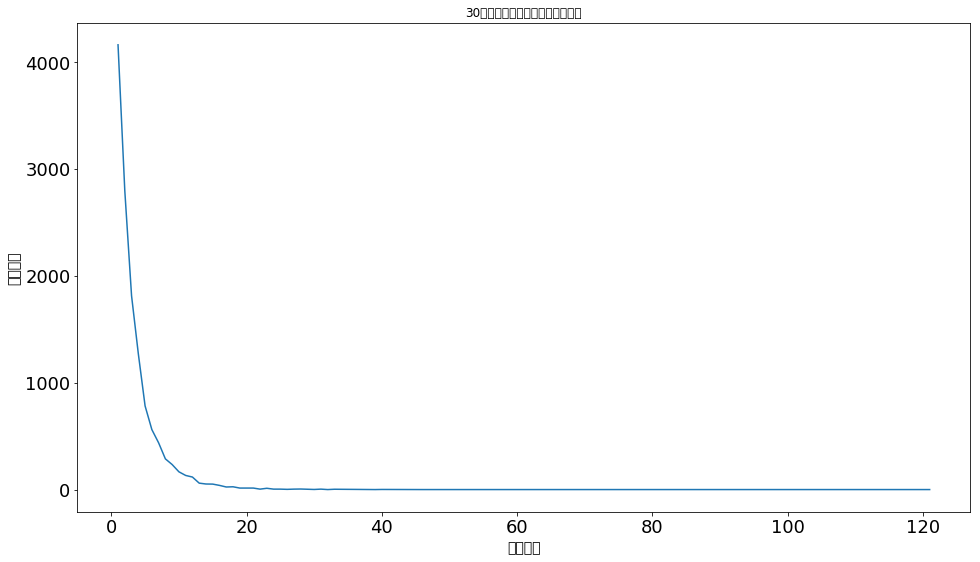

In [66]:
buy_active_level = labels['counts_30_buy'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16, 9))
plt.rc('font', family='Micosoft YaHei')
buy_active_level.plot(title='30天内购买次数与购买人数的关系', fontsize=18)
plt.ylabel('购买人数', fontsize=14)
plt.xlabel('购买次数', fontsize=14)

In [67]:
#定义购买次数小于等于14次的为低活跃，购买次数大于14次的定义为高活跃
labels['buy_active_level'] = '高' 
labels.loc[labels['counts_30_buy'] <= 14, 'buy_active_level'] = '低'
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,7.0,1.0,3.0,4.0,4.0,是,是,0,高,低
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,5.0,1.0,NaN,1.0,2.0,是,否,1,低,低
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,7.0,1.0,8.0,2.0,1.0,是,是,2,高,低
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,7.0,1.0,1.0,7.0,17.0,是,是,3,高,低
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,7.0,1.0,9.0,18.0,6.0,是,是,4,高,低
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,4.0,1.0,7.0,23.0,NaN,是,是,5,高,低
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,7.0,1.0,3.0,3.0,3.0,是,是,6,高,低
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,7.0,1.0,4.0,1.0,3.0,是,是,7,高,低
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,7.0,1.0,16.0,7.0,14.0,是,是,8,高,低
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,7.0,1.0,NaN,1.0,9.0,是,否,9,高,低


## 购买的品类是否单一

In [68]:
buy_single = df[df['behavior_type'] == 4].groupby('user_id').item_category.nunique().reset_index()
buy_single

,user_id,item_category
0,37101,1
1,45561,2
2,59436,2
3,61797,1
4,100605,3
5,106362,3
6,131694,3
7,137907,1
8,160959,4
9,169005,10


In [69]:
buy_single.rename(columns={'item_category':'buy_single'}, inplace=True)
buy_single

,user_id,buy_single
0,37101,1
1,45561,2
2,59436,2
3,61797,1
4,100605,3
5,106362,3
6,131694,3
7,137907,1
8,160959,4
9,169005,10


In [70]:
labels = pd.merge(labels, buy_single, how='left', on='user_id')
labels['buy_single'].unique()

array([14.,  3.,  6.,  4.,  1., 12.,  8.,  2., nan, 10.,  7.,  9., 13.,
        5., 20., 18., 26., 17., 15., 11., 16., 21., 19., 27., 47., 25.,
       24., 23., 22., 31., 28., 29., 37., 36.])

In [71]:
labels['buy_single'].fillna(-1, inplace=True)
labels['buy_single'] = labels['buy_single'].apply(lambda x: '是' if x>1 else '否' if x==1 else '未购买')
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,1.0,3.0,4.0,4.0,是,是,0,高,低,是
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,1.0,NaN,1.0,2.0,是,否,1,低,低,是
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,1.0,8.0,2.0,1.0,是,是,2,高,低,是
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,1.0,1.0,7.0,17.0,是,是,3,高,低,是
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,1.0,9.0,18.0,6.0,是,是,4,高,低,是
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,1.0,7.0,23.0,NaN,是,是,5,高,低,否
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,1.0,3.0,3.0,3.0,是,是,6,高,低,是
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,1.0,4.0,1.0,3.0,是,是,7,高,低,是
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,1.0,16.0,7.0,14.0,是,是,8,高,低,是
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,1.0,NaN,1.0,9.0,是,否,9,高,低,是


## 用户价值分组（RFM）

In [72]:
last_buy_days = labels['days_buy'].value_counts().sort_index()
last_buy_days

1.0      992
2.0      892
3.0      878
4.0      783
5.0      689
6.0      633
7.0     2169
8.0      407
9.0      396
10.0     356
11.0     337
12.0     320
13.0     317
14.0     284
15.0     352
16.0     332
17.0     287
18.0     258
19.0     260
20.0     224
21.0     201
22.0     206
23.0     167
24.0     201
25.0     217
26.0     164
27.0     169
28.0     141
29.0     183
30.0     168
31.0     152
Name: days_buy, dtype: int64

Text(0.5,0,'距今天数')

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Micosoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/fakue/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: 

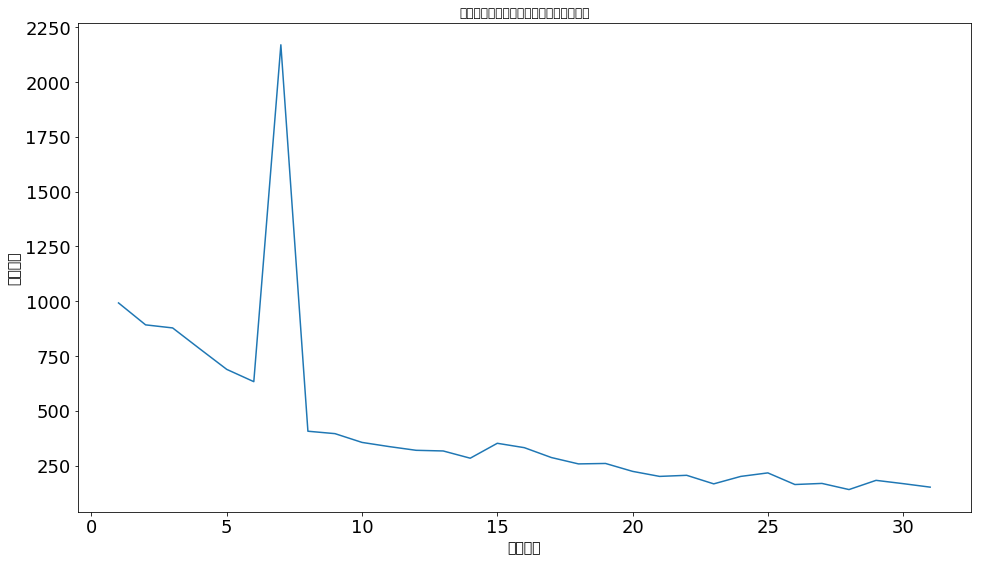

In [73]:
plt.figure(figsize=(16, 9))
last_buy_days.plot(title='最后一次购买距今天数与购买人数的关系', fontsize=18)
plt.ylabel('购买人数', fontsize=14)
plt.xlabel('距今天数', fontsize=14)

In [74]:
labels['buy_days_level'] = '高'
labels.loc[labels['days_buy']>8,'buy_days_level'] = '低'
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single,buy_days_level
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,3.0,4.0,4.0,是,是,0,高,低,是,高
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,NaN,1.0,2.0,是,否,1,低,低,是,高
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,8.0,2.0,1.0,是,是,2,高,低,是,高
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,1.0,7.0,17.0,是,是,3,高,低,是,高
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,9.0,18.0,6.0,是,是,4,高,低,是,低
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,7.0,23.0,NaN,是,是,5,高,低,否,低
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,3.0,3.0,3.0,是,是,6,高,低,是,高
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,4.0,1.0,3.0,是,是,7,高,低,是,高
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,16.0,7.0,14.0,是,是,8,高,低,是,高
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,NaN,1.0,9.0,是,否,9,高,低,是,高


In [75]:
labels['rfm_value'] = labels['buy_active_level'].str.cat(labels['buy_days_level'])
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single,buy_days_level,rfm_value
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,4.0,4.0,是,是,0,高,低,是,高,低高
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,1.0,2.0,是,否,1,低,低,是,高,低高
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,2.0,1.0,是,是,2,高,低,是,高,低高
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,7.0,17.0,是,是,3,高,低,是,高,低高
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,18.0,6.0,是,是,4,高,低,是,低,低低
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,23.0,NaN,是,是,5,高,低,否,低,低低
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,3.0,3.0,是,是,6,高,低,是,高,低高
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,1.0,3.0,是,是,7,高,低,是,高,低高
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,7.0,14.0,是,是,8,高,低,是,高,低高
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,1.0,9.0,是,否,9,高,低,是,高,低高


In [76]:
def trans_value(x):
    if x == '高高':
        return '重要价值客户'
    elif x == '低高':
        return '重要深耕客户'
    elif x == '高低':
        return '重要唤回客户'
    else: 
        return '即将流失客户'

In [77]:
labels['rfm'] = labels['rfm_value'].apply(trans_value)
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single,buy_days_level,rfm_value,rfm
0,58475394,下午,下午,9517,"725,5468,7079,9517,10258,10678","3321,3472,4091,9278,9517","603,2797,3472,3631,4373,4469,5579,6054,7117,90...",14.0,20.0,31,...,4.0,是,是,0,高,低,是,高,低高,重要深耕客户
1,12661032,上午,上午,5932,NaN,NaN,"9412,9457,12304",3.0,NaN,14,...,2.0,是,否,1,低,低,是,高,低高,重要深耕客户
2,4252574,上午,上午,1863,5894,11279,"284,1863,4676,11489,11537,11756",6.0,17.0,31,...,1.0,是,是,2,高,低,是,高,低高,重要深耕客户
3,10713699,晚上,晚上,6513,6513,13541,"5915,6717,9899,11695",4.0,18.0,30,...,17.0,是,是,3,高,低,是,高,低高,重要深耕客户
4,35111239,晚上,晚上,13230,2883,5503,"3662,4111,6344,9561",4.0,7.0,31,...,6.0,是,是,4,高,低,是,低,低低,即将流失客户
5,110937247,晚上,晚上,5027,NaN,"5204,5271",659,1.0,2.0,21,...,NaN,是,是,5,高,低,否,低,低低,即将流失客户
6,132791225,下午,下午,1863,NaN,"1863,3472",6344,13.0,31.0,24,...,3.0,是,是,6,高,低,是,高,低高,重要深耕客户
7,103044784,晚上,晚上,9569,NaN,9569,"2568,6000,7001,8077,8254,8561,11513,12170",8.0,13.0,31,...,3.0,是,是,7,高,低,是,高,低高,重要深耕客户
8,21578001,下午,下午,6513,"5689,6513","2950,3924,6513,11489","5399,6513",2.0,4.0,26,...,14.0,是,是,8,高,低,是,高,低高,重要深耕客户
9,62189225,晚上,晚上,5232,12685,NaN,"2825,3472,3628,4370,4963,5232,6255,7516,7957,9...",12.0,NaN,30,...,9.0,是,否,9,高,低,是,高,低高,重要深耕客户


In [78]:
labels['rfm'].value_counts()

重要深耕客户    7199
重要价值客户    7063
即将流失客户    5679
重要唤回客户      13
Name: rfm, dtype: int64